In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
print("Downloading Ames Housing dataset... this might take a moment")
#using ID 42165 which is standard Ames Housing dataset on OpenML
housing = fetch_openml(data_id=42165, as_frame=True, parser='auto')
ames = housing.frame
print(f"Dataset Loaded: {ames.shape[0]} rows, {ames.shape[1]} columns") 

Dataset Loaded: 1460 rows, 81 columns


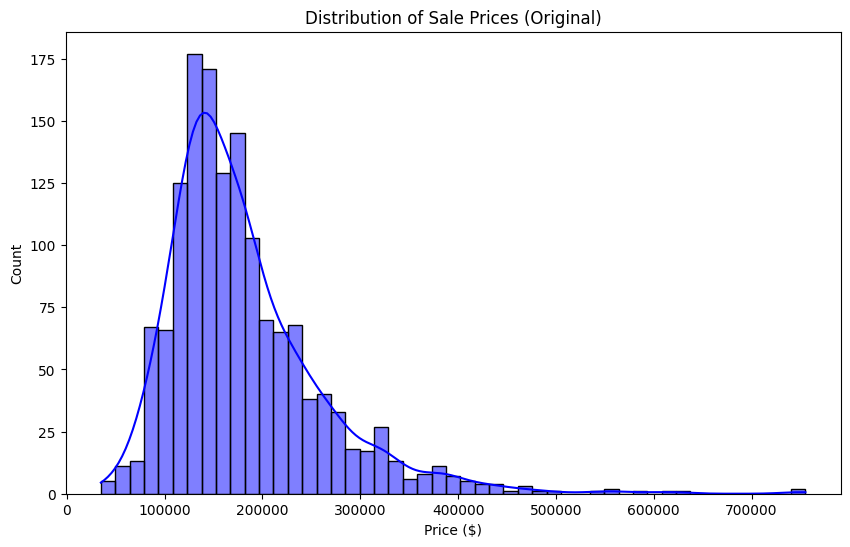

In [11]:
#looking at the target variable - SalePrice
plt.figure(figsize=(10,6))
sns.histplot(ames['SalePrice'], kde=True, color='blue')
plt.title('Distribution of Sale Prices (Original)')
plt.xlabel('Price ($)')
plt.show() 

In [12]:
#calculating Skewness
print(f"Skewness: {ames['SalePrice'].skew():.2f}") 

Skewness: 1.88


In [13]:
#applying log transformation
#using log1p (log(1+x)) to avoid errors if price is ever 0
ames['SalePrice_Log'] = np.log1p(ames['SalePrice'])

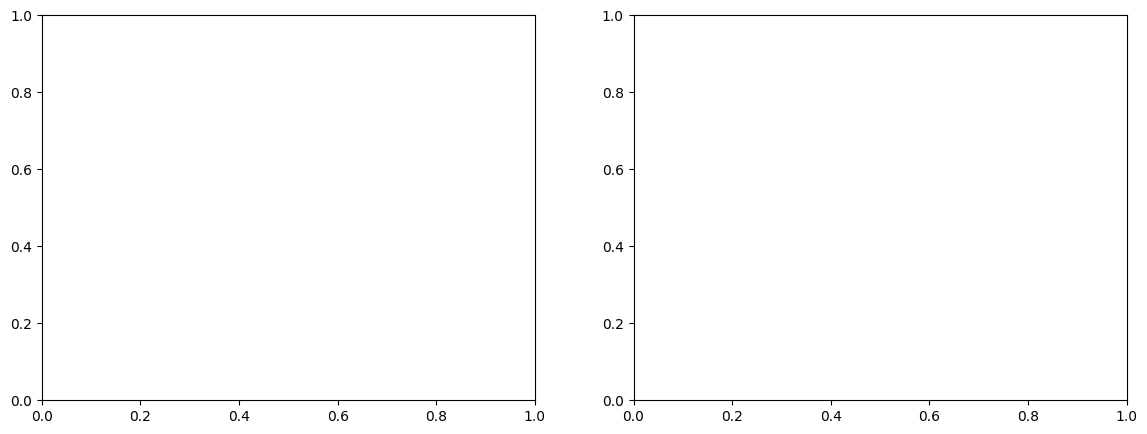

In [14]:
#comparing before and after
fig, ax = plt.subplots(1, 2, figsize=(14, 5)) 

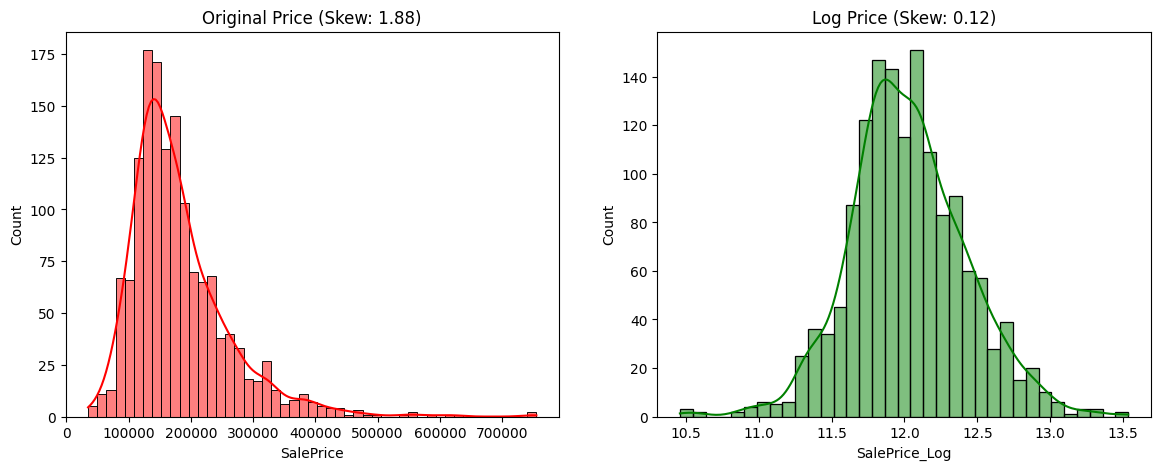

In [15]:
#creating the Log Transformed column first
ames['SalePrice_Log'] = np.log1p(ames['SalePrice'])

#creating the blank canvases
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#plotting first plot (ax[0])
sns.histplot(ames['SalePrice'], kde=True, ax=ax[0], color='red')
ax[0].set_title(f"Original Price (Skew: {ames['SalePrice'].skew():.2f})")

#plotting second plot (ax[1])
sns.histplot(ames['SalePrice_Log'], kde=True, ax=ax[1], color='green')
ax[1].set_title(f"Log Price (Skew: {ames['SalePrice_Log'].skew():.2f})")
plt.show()

In [16]:
#handling missing data
#calculating missing % per column
missing = ames.isnull().sum()
missing = missing[missing > 0]
missing_percent = (missing / len(ames)) * 100

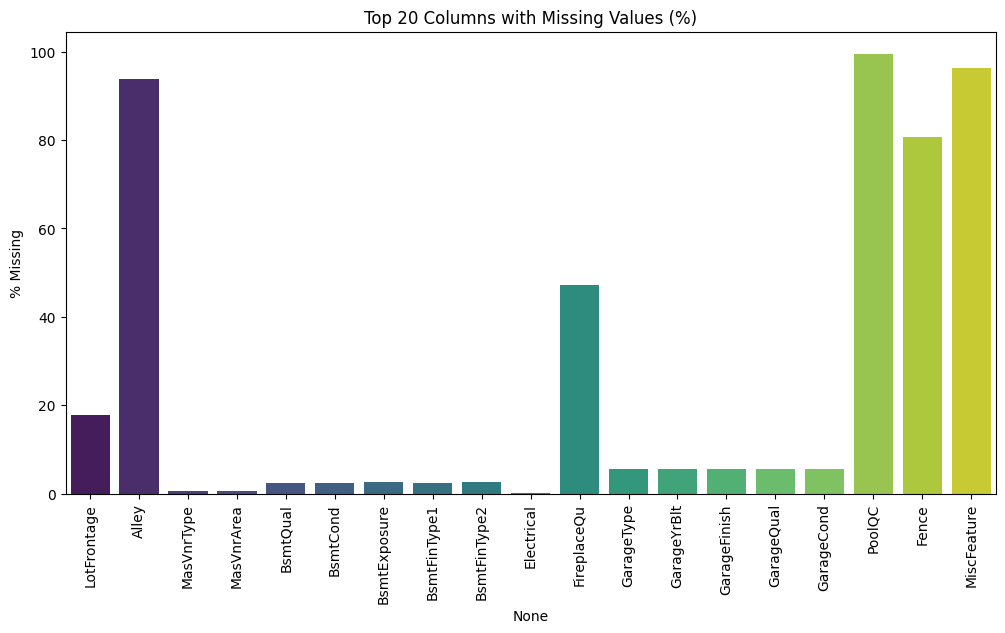

In [17]:
#sorting cleaned data, adding visuals
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percent.index[:20], y=missing_percent.values[:20], palette='viridis')
plt.xticks(rotation=90)
plt.title("Top 20 Columns with Missing Values (%)")
plt.ylabel("% Missing")
plt.show() 

In [18]:
#categorical Columns where NaN means "Does not exist"
#filling these with the string "None"
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'MasVnrType']

for col in cols_fill_none:
    ames[col] = ames[col].fillna("None")

#numerical Columns where NaN means "0" (No garage = 0 cars)
cols_fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                  'MasVnrArea']

for col in cols_fill_zero:
    ames[col] = ames[col].fillna(0)

#real missing values (LotFrontage)
#for street frontage, filling with the median of the neighborhood (or just global median.. idk)
ames['LotFrontage'] = ames['LotFrontage'].fillna(ames['LotFrontage'].median())

#filling remaining tiny gaps (like Electrical) with the most common value (Mode)
for col in ames.columns:
    if ames[col].isnull().sum() > 0:
        ames[col] = ames[col].fillna(ames[col].mode()[0])

#FEATURE ENGINEERING
#creating a "Total Square Footage" column
#this combines Basement + 1st Floor + 2nd Floor
ames['TotalSF'] = ames['TotalBsmtSF'] + ames['1stFlrSF'] + ames['2ndFlrSF']

#crosschecks
print(f"Remaining Missing Values: {ames.isnull().sum().sum()}")

Remaining Missing Values: 0


In [22]:
#encoding and splitting
from sklearn.model_selection import train_test_split
#separating target (y) and features (x)
#using LOG price as target
y = ames['SalePrice_Log']

#dropping useless things from features
x = ames.drop(['SalePrice', 'SalePrice_Log', 'Id'], axis=1) 

In [23]:
#one-hot encoding
#converting all text columns into binary columns
x = pd.get_dummies(x, drop_first=True)
print(f"New Feature Count: {x.shape[1]}")

New Feature Count: 260


In [24]:
#splitting into train ans test
#using 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Data Successfully Split!") 

Data Successfully Split!


In [26]:
#regularization model using ridge regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
#training model
#using alpha=10 as its the strength of the regularization
model = Ridge(alpha=10)
model.fit(x_train, y_train) 

,alpha,10
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [27]:
#prediction
y_pred_log = model.predict(x_test)

In [28]:
#evaluation (RMSE)
#calculating errors
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
print(f"Log RMSE: {rmse:.4}")

Log RMSE: 0.139


In [29]:
#converting back to $
#using first 5 predcitons
real_predictions = np.expm1(y_pred_log[:5])
real_actuals = np.expm1(y_test[:5].values)

print("\n--- Real Dollar Check (First % Houses) ---")
for pred, act in zip(real_predictions, real_actuals):
    print(f"Predicted: ${pred:,.0} | Actual: ${act:,.0f} | Diff: ${pred - act:,.0f}")



--- Real Dollar Check (First % Houses) ---
Predicted: $2e+05 | Actual: $154,500 | Diff: $2,701
Predicted: $3e+05 | Actual: $325,000 | Diff: $-3,475
Predicted: $1e+05 | Actual: $115,000 | Diff: $-12,308
Predicted: $2e+05 | Actual: $159,000 | Diff: $596
Predicted: $3e+05 | Actual: $315,500 | Diff: $4,507
